# Scaling of the maximum energy vs the number of virtual orbitals for $N_2$

We consider a $N_2$ molecule and we determine the maximum energy, that is the energy of the last virtual orbital in function of the number of virtual orbitals.

In [11]:
#%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
inputpath = 'testfiles/N2maxEngVorb/input/'

## Analysis for rmult =[7.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         #'output_denspot': 22, # save density on file
         'itermax_virt' : 100},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [3]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [4]:
norb=[16,32,64,128,256]

In [5]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult7_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [6]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2_rmult7_*
print(logs)
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

['testfiles/N2maxEngVorb/log/log-N2_rmult7_norb128.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult7_norb16.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult7_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult7_norb32.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult7_norb64.yaml']


5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [7]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 16, 256, 32, 64]
[1.1027915636540699, 0.263960940944718, 1.63042469076101, 0.34660221454630702, 0.64012205126697297]


and we sort their argument according the number ov virtual orbitals:

In [8]:
l = np.argsort(Norbv)
l

array([1, 3, 4, 0, 2])

In [9]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64, 128, 256]
[0.263960940944718, 0.34660221454630702, 0.64012205126697297, 1.1027915636540699, 1.63042469076101]


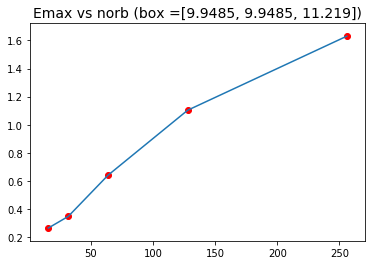

In [10]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

To check for the convergence of the orbitals we perform a run with the Davison algorithm

In [11]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 2},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

Yaml.dump(inp0,inputpath + 'default.yaml')

inp={'dft':{'norbv': 256, 'nvirt' : 256}}

inpname = 'N2_Davidson_rmult7_norb256'
Yaml.dump(inp,inputpath + inpname + '.yaml')

We see that the Davidson algorithm does not improve the convergence and we use the orbitals built with the former method.

### Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e-2$ both in the $z$ and $x$ directions. The orbitals of the perturbed system have been computed for rmult = [7.0 , 9.0]

In [12]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 100},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,inputpath + 'default.yaml')

The path of the $psi'$ orbitals must be given in as a relative path starting from the folder that contains the log files. 
For the second run, the one with the $E_z$ perturbation in this case, we don't write the resulting wf on the disk and set itermax_virt : 1, in this way the simulation only perform the scalar product of the states given as input with the perturbed wf

In [13]:
n = 256
Ex_psip = '../data-Ex_1em2_rmult_7/'
Ez_psip = '../data-Ez_1em2_rmult_7/'
inpEx={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ex_psip}}
inpEz={'dft':
       {'norbv': -n,
       'output_wf': 0,
       'itermax_virt' : 1},
       'tddft':{'decompose_perturbation': Ez_psip}}
ExInpname = 'N2Ex_rmult7_norb'+str(n)
EzInpname = 'N2Ez_rmult7_norb'+str(n)

Yaml.dump(inpEz,inputpath + EzInpname + '.yaml')
Yaml.dump(inpEx,inputpath + ExInpname + '.yaml')

Now we import the result and perform the data analysis

In [14]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2E*_rmult7_norb256.yaml
print(logs)
N2data=[lf.Logfile(l) for l in logs]

['testfiles/N2maxEngVorb/log/log-N2Ex_rmult7_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2Ez_rmult7_norb256.yaml']


We define the  following list of arrays (the first element correponds to Ex, the second to Ez): 

In [15]:
coeff_occ = [n.log['<psi_i|psi_j>'] for n in N2data]
coeff_occ=np.double(np.array(coeff_occ))

coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in N2data]
coeff_vrt=np.double(np.array(coeff_vrt))

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

We also read other useful quantities (we define common quantities for both Ex and Ez since the orbitals are the same)

In [16]:
n_occ,n_vrt = coeff_vrt[0].shape
print 'no_occ',n_occ, 'n_vrt', n_vrt
en = N2data[0].evals[0][0]
e_v=[]
e_o=[]
for o in range(n_occ):
    e_o.append(en[o])
for v in range(n_occ,n_occ+n_vrt):
    e_v.append(en[v])


no_occ 5 n_vrt 256


In [17]:
# we compute the norm of the perturbed orbitals projected on the basis of the occupied states
psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
for o in range(n_occ):
    psiprimeEx += coeff_occ[0][o]**2
    psiprimeEz += coeff_occ[1][o]**2
# we quantify the magnitude of the missing part
psiprimeEx = 1.0-psiprimeEx
psiprimeEz = 1.0-psiprimeEz
print 'psiprimeEx Norm ',np.sqrt(psiprimeEx)
print 'psiprimeEz Norm ',np.sqrt(psiprimeEz)
# and we find the maximum value
referenceEx=np.max(psiprimeEx)
referenceEz=np.max(psiprimeEz)
# we add the contribution of the empty orbitals
crEx=[[] for p in range(n_occ)]
crEz=[[] for p in range(n_occ)]
for p in range(n_occ):
    for v in range(n_vrt):
      psiprimeEx[p] -= coeff_vrt[0][p][v]**2
      psiprimeEz[p] -= coeff_vrt[1][p][v]**2    
      crEx[p].append(psiprimeEx[p]/referenceEx)
      crEz[p].append(psiprimeEz[p]/referenceEz)

psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]


In [18]:
#to display the plot in a separate window
#%matplotlib auto
#to display back in the nb
#%matplotlib inline 

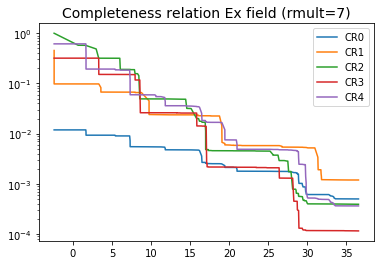

In [19]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEx[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ex field (rmult=7)', fontsize=14)
plt.show()

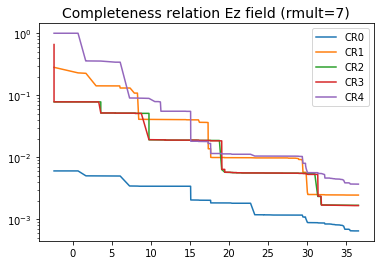

In [20]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEz[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ez field (rmult=7)', fontsize=14)
plt.show()

## Analysis for rmult =[9.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [21]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [9.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 100},
        'radical': 'N2_rmult9', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [22]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [23]:
norb=[16,32,64,128,256]

In [24]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult9_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [25]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2_rmult9_*
print(logs)
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

['testfiles/N2maxEngVorb/log/log-N2_rmult9_norb128.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb16.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb32.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb64.yaml']


5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [26]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 16, 256, 32, 64]
[0.65415558358574399, 0.18400946793181, 1.00658767681626, 0.27083912161076301, 0.39650250629308398]


and we sort their argument according the number ov virtual orbitals:

In [27]:
l = np.argsort(Norbv)
l

array([1, 3, 4, 0, 2])

In [28]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64, 128, 256]
[0.18400946793181, 0.27083912161076301, 0.39650250629308398, 0.65415558358574399, 1.00658767681626]


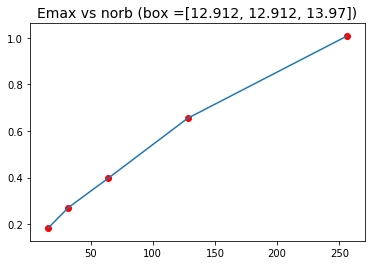

In [29]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

### Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e-2$ both in the $z$ and $x$ directions. The orbitals of the perturbed system have been computed for rmult = [9.0 , 9.0]

In [30]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [9.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 0,
         'itermax_virt' : 1},
        'radical': 'N2_rmult9', #always in the same directory
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,inputpath + 'default.yaml')

We don't write the resulting wf on the disk and set itermax_virt : 1, in this way the simulation only perform the scalar product of the states given as input with the perturbed wf

In [31]:
n = 256
Ex_psip = '../data-Ex_1em2_rmult_9/'
Ez_psip = '../data-Ez_1em2_rmult_9/'
inpEx={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ex_psip}}
inpEz={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ez_psip}}
ExInpname = 'N2Ex_rmult9_norb'+str(n)
EzInpname = 'N2Ez_rmult9_norb'+str(n)

Yaml.dump(inpEz,inputpath + EzInpname + '.yaml')
Yaml.dump(inpEx,inputpath + ExInpname + '.yaml')

Now we import the result and perform the data analysis

In [32]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2E*_rmult9_norb256.yaml
print(logs)
N2data=[lf.Logfile(l) for l in logs]

['testfiles/N2maxEngVorb/log/log-N2Ex_rmult9_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2Ez_rmult9_norb256.yaml']


We define the  following list of arrays (the first element correponds to Ex, the second to Ez): 

In [33]:
coeff_occ = [n.log['<psi_i|psi_j>'] for n in N2data]
coeff_occ=np.double(np.array(coeff_occ))

coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in N2data]
coeff_vrt=np.double(np.array(coeff_vrt))

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

We also read other useful quantities (we define common quantities for both Ex and Ez since the orbitals are the same)

In [34]:
n_occ,n_vrt = coeff_vrt[0].shape
print 'no_occ',n_occ, 'n_vrt', n_vrt
en = N2data[0].evals[0][0]
e_v=[]
e_o=[]
for o in range(n_occ):
    e_o.append(en[o])
for v in range(n_occ,n_occ+n_vrt):
    e_v.append(en[v])


no_occ 5 n_vrt 256


In [35]:
# we compute the norm of the perturbed orbitals projected on the basis of the occupied states
psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
for o in range(n_occ):
    psiprimeEx += coeff_occ[0][o]**2
    psiprimeEz += coeff_occ[1][o]**2
# we quantify the magnitude of the missing part
psiprimeEx = 1.0-psiprimeEx
psiprimeEz = 1.0-psiprimeEz
print 'psiprimeEx Norm ',np.sqrt(psiprimeEx)
print 'psiprimeEz Norm ',np.sqrt(psiprimeEz)
# and we find the maximum value
referenceEx=np.max(psiprimeEx)
referenceEz=np.max(psiprimeEz)
# we add the contribution of the empty orbitals
crEx=[[] for p in range(n_occ)]
crEz=[[] for p in range(n_occ)]
for p in range(n_occ):
    for v in range(n_vrt):
      psiprimeEx[p] -= coeff_vrt[0][p][v]**2
      psiprimeEz[p] -= coeff_vrt[1][p][v]**2    
      crEx[p].append(psiprimeEx[p]/referenceEx)
      crEz[p].append(psiprimeEz[p]/referenceEz)

psiprimeEx Norm  [ 0.00126599  0.01044813  0.01163324  0.00656826  0.00913968]
psiprimeEz Norm  [ 0.00110997  0.00760269  0.01161194  0.01161194  0.01434794]


In [36]:
#to display the plot in a separate window
#%matplotlib auto
#to display back in the nb
#%matplotlib inline 

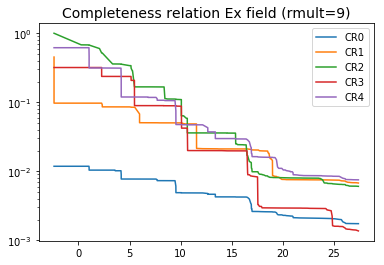

In [37]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEx[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ex field (rmult=9)', fontsize=14)
plt.show()

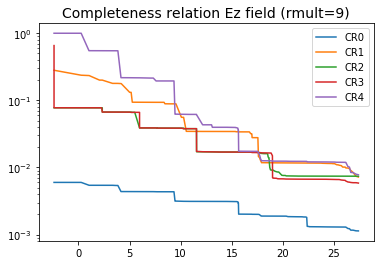

In [38]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEz[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ez field (rmult=9)', fontsize=14)
plt.show()